# Import relevant libraries

Let's import the relevant libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LogisticRegression

# Import and explore the data

Let's import the data

In [2]:
inp_file = pd.read_csv('signal-data.csv')

In [3]:
inp_file.head()

,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


We can see that there are plenty of columns(592)

Let's check if there are any missing values

In [4]:
missing = pd.DataFrame(inp_file.isnull().mean() * 100).iloc[1:].reset_index()
missing.columns = ["index","missing_perc"]
missing

,index,missing_perc
0,0,0.382897
1,1,0.446713
2,2,0.893427
3,3,0.893427
4,4,0.893427
...,...,...
586,586,0.063816
587,587,0.063816
588,588,0.063816
589,589,0.063816


Let's drop all the variables with more than 50% missing values later

In [5]:
drop_miss = list(missing[missing["missing_perc"] > 0.5]["index"])

We can also see that there are plenty of variables with 0 values. Let's check their percentage

In [6]:
zeros = pd.DataFrame((inp_file == 0).mean())[1:].reset_index()
zeros.columns = ["index","zero_perc"]
zeros

,index,zero_perc
0,0,0.000000
1,1,0.000000
2,2,0.000000
3,3,0.000638
4,4,0.000000
...,...,...
586,586,0.000000
587,587,0.000000
588,588,0.000000
589,589,0.020421


We can drop the columns that are all zeros

In [7]:
drop_zeros = list(zeros[zeros["zero_perc"] >= 0.99]["index"])

We will drop missing columns and zeros in the next step

Let's proceed ahead to check the distribution of the dependent variable which is 'Pass/Fail'

In [8]:
inp_file['Pass/Fail'].value_counts()

-1    1463
 1     104
Name: Pass/Fail, dtype: int64

We can see there is a huge imbalance. We will apply upsampling to the data at a later stage in order to reduce the effect of imbalance while training the data

# Data cleansing

We will drop the Time variable entirely from the dataset as it doesn't explain the output

In [9]:
inp_file = inp_file.drop(columns='Time')

We will next drop the missing and zero columns we found in the previous step. We will first remove any duplicates present in both the lists

In [10]:
def clean_cols(x,y):
    for i in y:
        if i not in x:
            x.append(i)
    return(x)

In [11]:
drop_cols = clean_cols(drop_miss,drop_zeros)

In [12]:
len(drop_cols)

268

Let's now drop the missing columns and zero columns we found in the above step

In [13]:
inp_file.drop(drop_cols,axis=1,inplace=True)

Let's capture the remaining fields in a variable

In [14]:
clean_cols = inp_file.columns

We will apply missing value treatment at a later stage

We will apply all relevant modifications on the data using both functional/logical reasoning/assumptions along the way

# Data analysis & visualisation

Let's look at the stats

In [15]:
inp_file.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
0,1561.0,3014.452896,73.621787,2743.2400,2966.260000,3011.4900,3056.6500,3356.3500
1,1560.0,2495.850231,80.407705,2158.7500,2452.247500,2499.4050,2538.8225,2846.4400
8,1565.0,1.462862,0.073897,1.1910,1.411200,1.4616,1.5169,1.6564
9,1565.0,-0.000841,0.015116,-0.0534,-0.010800,-0.0013,0.0084,0.0749
10,1565.0,0.000146,0.009302,-0.0349,-0.005600,0.0004,0.0059,0.0530
...,...,...,...,...,...,...,...,...
586,1566.0,0.021458,0.012358,-0.0169,0.013425,0.0205,0.0276,0.1028
587,1566.0,0.016475,0.008808,0.0032,0.010600,0.0148,0.0203,0.0799
588,1566.0,0.005283,0.002867,0.0010,0.003300,0.0046,0.0064,0.0286
589,1566.0,99.670066,93.891919,0.0000,44.368600,71.9005,114.7497,737.3048


We can see that some variables are skewed

In [16]:
stats = pd.DataFrame(inp_file.describe().transpose())
stats["Deviation"] = abs((stats["50%"] - stats["mean"])/stats["mean"])
stats[stats['Deviation'] > 0.25]

,count,mean,std,min,25%,50%,75%,max,Deviation
9,1565.0,-0.000841,0.015116,-0.0534,-0.010800,-0.00130,0.008400,0.0749,0.545738
10,1565.0,0.000146,0.009302,-0.0349,-0.005600,0.00040,0.005900,0.0530,1.744410
24,1565.0,-298.598136,2902.690117,-14804.5000,-1476.000000,-78.75000,1377.250000,14106.0000,0.736268
59,1560.0,2.960241,9.532220,-28.9882,-1.871575,0.94725,4.385225,168.1455,0.680009
67,1561.0,16.715444,307.502293,0.4137,0.890700,0.97830,1.065000,7272.8283,0.941473
...,...,...,...,...,...,...,...,...,...
523,1567.0,0.453896,4.147581,0.0258,0.073050,0.10000,0.133200,111.3330,0.779685
572,1567.0,28.450165,86.304681,3.5400,7.500000,8.65000,10.130000,454.5600,0.695960
574,1567.0,9.162315,26.920150,1.0395,2.567850,2.97580,3.492500,170.0204,0.675213
576,1567.0,5.563747,16.921369,0.6636,1.408450,1.62450,1.902000,90.4235,0.708020


We can see that there are 63 columns with more than moderate skewness

Since the number of dimensions is very high, it is not entirely possible to perform univariate and bivariate analysis. Let's do a heat map at a high level to understand the general nature of the data

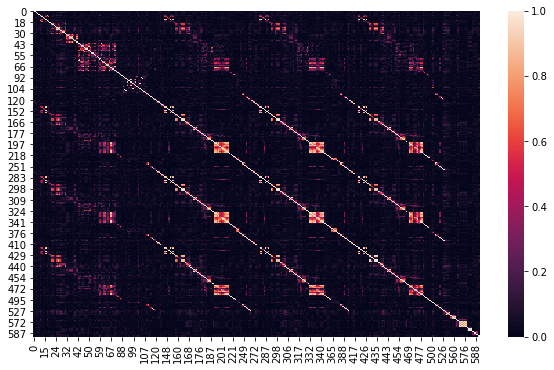

In [17]:
plt.figure(figsize = (10,6))
sns.heatmap(abs(inp_file.corr()), vmin = 0, vmax = 1)
plt.show()

We can see most of the variables are not correlated with each other. We can nevertheless see a few variables that are highly correlated with each other

We will remove the columns not explaining much using feature importance and PCA

# Data pre-processing

Let's split the data into train and test and only use the train for our analysis and model preparation to avoid data leakage. We will use the test data finally to test the model developed by using the train data entirely. We will split the data in the ration of 70:30

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
train,test = train_test_split(inp_file,train_size=0.7,random_state=1)

In [20]:
train['Pass/Fail'].value_counts()

-1    1024
 1      72
Name: Pass/Fail, dtype: int64

We can see that data is highly imbalanced. We will use smote package along the way to balance it. We will check if the train and test have similar characteristics to the original data

<b>Original Data</b>

In [21]:
inp_file['Pass/Fail'].value_counts()

-1    1463
 1     104
Name: Pass/Fail, dtype: int64

In [22]:
1463/104

14.067307692307692

This is a ratio of 14.067. Let's check the other ratios

<b>Train Data</b>

In [23]:
train['Pass/Fail'].value_counts()

-1    1024
 1      72
Name: Pass/Fail, dtype: int64

In [24]:
1024/72

14.222222222222221

This is almost similar to the original data

<b>Test Data</b>

In [25]:
test['Pass/Fail'].value_counts()

-1    439
 1     32
Name: Pass/Fail, dtype: int64

In [26]:
439/32

13.71875

This is a little different but not very different nevertheless from the original. For all practical purposes this can be considered similar to the original dataset

We will fit a Random Forest Model to find the most important variables. We will do imputation, oversampling, scaling and PCA along the way to make the model more manageable

In [27]:
from sklearn.impute import SimpleImputer

We will use median imputation to avoid the effect of outliers

In [28]:
impute = SimpleImputer(strategy='median')

In [29]:
inp_file_clean = pd.DataFrame(impute.fit_transform(train),columns=train.columns)

We will do oversampling using SMOTE and the target distribution is the minority class should be 30% of the majority class

In [30]:
from imblearn.over_sampling import SMOTE

In [31]:
oversample = SMOTE(sampling_strategy=0.3)

In [32]:
X = inp_file_clean.drop(columns='Pass/Fail')
y = inp_file_clean['Pass/Fail']

In [33]:
X_sm,y_sm = oversample.fit_resample(X,y)

In [34]:
y_sm.value_counts()

-1.0    1024
 1.0     307
Name: Pass/Fail, dtype: int64

We can see that SMOTE has indeed changed the distribution of the minority class to 30% of that of the majority class.

<b>Feature Importances</b>

Let's now fit the random forest model to know the feature importances

In [35]:
from sklearn.ensemble import RandomForestClassifier

In [36]:
rf = RandomForestClassifier(random_state=1)
rf.fit(X_sm,y_sm)

RandomForestClassifier(random_state=1)

Let's see the contribution of the variables in explaining the outcome

In [37]:
indices = rf.feature_importances_.argsort()[::-1]
features = X.columns

In [38]:
Imp = pd.Series(features[indices])
Score = pd.Series(rf.feature_importances_[indices])

In [39]:
Feat_Scores = pd.concat([Imp,Score],axis=1)
Feat_Scores.columns = ["Feature","Score"]

In [40]:
Feat_Scores['Cum'] = np.cumsum(Feat_Scores['Score'])

Let's see how many of the variables explain 95% of the data

In [41]:
Feat_Scores[Feat_Scores['Cum'] < 0.95]

,Feature,Score,Cum
0,59,0.033511,0.033511
1,95,0.010547,0.044057
2,200,0.009885,0.053943
3,103,0.009772,0.063715
4,510,0.009505,0.073220
...,...,...,...
275,177,0.001626,0.942536
276,101,0.001624,0.944160
277,281,0.001622,0.945782
278,56,0.001615,0.947397


We can see that 280 features explain almostt 95% of the data.

Let's only include these features

In [42]:
Feat_Scores = Feat_Scores[Feat_Scores['Cum'] < 0.95]

In [43]:
Select_Data = X_sm[list(Feat_Scores['Feature'])]

In [44]:
Select_Data.shape

(1331, 280)

Since there are too many features, let's apply PCA and reduce the number of dimensions. We will first scale the data and then apply PCA

In [45]:
X = Select_Data

In [46]:
from sklearn.preprocessing import MinMaxScaler

In [47]:
mmscaler = MinMaxScaler()
X = pd.DataFrame(mmscaler.fit_transform(X),columns=X.columns)

In [48]:
from sklearn.decomposition import PCA

In [49]:
pca = PCA(n_components=150,random_state=1)
pca_X = pca.fit_transform(X)

In [50]:
sum(pca.explained_variance_ratio_)

0.9966326143239966

We can see that 150 components explain more than 99% of the total variation. So let's only include these 150 in our model.

# Model training, testing and tuning

We will now try the different supervised machine learning algorithms

We will do two iterations. The first time, we will try to maximize the accuracy. Since our dataset is highly skewed, we will try to improve the recall for the minority class in the second iteration as accuracy is likely to be biased to the majority class.

# Logistic Regression

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score,KFold
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.fixes import loguniform
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [52]:
lr = LogisticRegression(random_state=1)

# KFold

In [53]:
from sklearn.model_selection import KFold,cross_val_score

In [54]:
kfold = KFold(n_splits=5,shuffle=True,random_state=1)

In [55]:
results = cross_val_score(lr,pca_X,y_sm,scoring='accuracy',cv=kfold)

In [56]:
results.mean()

0.8286728056095294

We can see that we are getting a score of 81.7%. Let's next try Grid Search CV

# GridsearchCV

In [57]:
param_grid_lr = {'C': [0.0001,0.001,0.01,0.1, 1, 10, 100,1000,10000],  
              'penalty': ['none', 'l1', 'l2', 'elasticnet'],
              'solver': ['newton-cg', 'lbfgs', 'liblinear']}  

<b>Accuracy</b>

In [58]:
grid = GridSearchCV(lr, param_grid_lr, n_jobs=-1,scoring='accuracy')

In [295]:
grid.fit(pca_X,y_sm)

In [60]:
grid.best_params_

{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}

In [61]:
grid.best_score_

0.8640224155895357

We can see that the maximum score is 86.77% with GridSearchCV

<b>Recall</b>

We will use recall_micro for scoring as we are concerned about the minority class as well

In [62]:
grid = GridSearchCV(lr, param_grid_lr, n_jobs=-1,scoring='recall_micro')

In [296]:
grid.fit(pca_X,y_sm)

In [64]:
grid.best_params_

{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}

In [65]:
grid.best_score_

0.8640224155895357

This is the same as that of accuracy

# RandomizedsearchCV

Let's next use RandomizedsearchCV

<b>Accuracy</b>

In [66]:
param_dist_lr = {'C': loguniform(1e-6, 1e+6),
 'penalty': ['none', 'l1', 'l2', 'elasticnet'],
 'solver': ['newton-cg', 'lbfgs', 'liblinear']}

In [67]:
samples = 100
randomCV_lr = RandomizedSearchCV(lr,param_distributions=param_dist_lr,n_iter=samples,scoring='accuracy')

In [297]:
randomCV_lr.fit(pca_X,y_sm)

Let's check the best parameters

In [69]:
randomCV_lr.best_params_

{'C': 18.04906763213572, 'penalty': 'l1', 'solver': 'liblinear'}

Let's check the best score

In [70]:
randomCV_lr.best_score_

0.8647827433752923

<b>Recall</b>

In [71]:
param_dist_lr = {'C': loguniform(1, 3000),
 'penalty': ['none', 'l1', 'l2', 'elasticnet'],
 'solver': ['newton-cg', 'lbfgs', 'liblinear']}

In [72]:
samples = 1000
randomCV_lr = RandomizedSearchCV(lr,param_distributions=param_dist_lr,n_iter=samples,scoring='recall_micro')

In [298]:
randomCV_lr.fit(pca_X,y_sm)

In [74]:
randomCV_lr.best_params_

{'C': 7.5673119519519965, 'penalty': 'l1', 'solver': 'liblinear'}

In [75]:
randomCV_lr.best_score_

0.8677874461434485

This is same as that of accuracy

We are getting almost the same score as that of GridsearchCV

Let's next use Naive Baye's

# Naive Baye's

In [76]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

In [77]:
nb = GaussianNB()

In [78]:
result = cross_val_score(nb,pca_X,y_sm,cv=10,scoring='accuracy')

In [79]:
result.mean()

0.8655313657277521

The accuracy is pretty high! We will not apply any tuning for this as Naive Bayes's doesn't have many tuning options

Let's next try support vector machines

# Support Vector Machines

In [80]:
from sklearn.svm import SVC

# KFold

In [81]:
kfold = KFold(n_splits=5,shuffle=True,random_state=1)

In [82]:
results = cross_val_score(SVC(random_state=1),pca_X,y_sm,scoring='accuracy',cv=kfold)

In [83]:
results.mean()

0.9631747909098589

The result of 96.31 is really great. Let's next apply GridSearch CV

# GridsearchCV

<b>Accuracy</b>

In [84]:
param_grid_svm = {'C': [0.01,0.1, 1, 10, 100,200,300,400,500], 
                 'gamma': [0.00001,0.0001,0.0005,0.001,0.01,0.1, 1, 10, 100],
                 'class_weight' : [None,'balanced']}  

In [85]:
grid = GridSearchCV(SVC(random_state=1), param_grid_svm, n_jobs=-1,scoring='accuracy')

In [86]:
grid.fit(pca_X,y_sm)

GridSearchCV(estimator=SVC(random_state=1), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 200, 300, 400, 500],
                         'class_weight': [None, 'balanced'],
                         'gamma': [1e-05, 0.0001, 0.0005, 0.001, 0.01, 0.1, 1,
                                   10, 100]},
             scoring='accuracy')

In [87]:
grid.best_params_

{'C': 1, 'class_weight': 'balanced', 'gamma': 1}

In [88]:
grid.best_score_

0.9902537241981358

This is an improvement over base model

<b>Recall</b>

In [89]:
grid = GridSearchCV(SVC(random_state=1), param_grid_svm, n_jobs=-1,scoring='recall_micro')

In [90]:
grid.fit(pca_X,y_sm)

GridSearchCV(estimator=SVC(random_state=1), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 200, 300, 400, 500],
                         'class_weight': [None, 'balanced'],
                         'gamma': [1e-05, 0.0001, 0.0005, 0.001, 0.01, 0.1, 1,
                                   10, 100]},
             scoring='recall_micro')

In [91]:
grid.best_params_

{'C': 1, 'class_weight': 'balanced', 'gamma': 1}

In [92]:
grid.best_score_

0.9902537241981358

This is the same as we saw that for accuracy. Next let's try RandomizedsearchCV

# RandomizedsearchCV

In [93]:
param_dist_svm = {'C': loguniform(1e-3, 1e3),
 'gamma': loguniform(1e-6, 1e+1),
 'kernel': ['rbf','sigmoid','linear'],
 'class_weight':['balanced', None]}

<b>Accuracy</b>

In [95]:
svm = SVC(random_state=1)

In [96]:
samples = 60
randomCV_svm = RandomizedSearchCV(svm,param_distributions=param_dist_svm,n_iter=samples,scoring='accuracy')

In [97]:
randomCV_svm.fit(pca_X,y_sm)

RandomizedSearchCV(estimator=SVC(random_state=1), n_iter=60,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000112AFA7B790>,
                                        'class_weight': ['balanced', None],
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000112AF8AA3D0>,
                                        'kernel': ['rbf', 'sigmoid', 'linear']},
                   scoring='accuracy')

In [98]:
randomCV_svm.best_params_

{'C': 36.654878864748305,
 'class_weight': 'balanced',
 'gamma': 0.786577385253692,
 'kernel': 'rbf'}

In [99]:
randomCV_svm.best_score_

0.992506547267044

<b>Recall</b>

In [100]:
param_dist_svm = {'C': loguniform(1e0, 1e3),
 'gamma': loguniform(1e-4, 1e-3),
 'kernel': ['rbf','sigmoid','linear'],
 'class_weight':['balanced', None]}

In [101]:
samples = 60
randomCV_svm = RandomizedSearchCV(svm,param_distributions=param_dist_svm,n_iter=samples,scoring='recall_micro')

In [102]:
randomCV_svm.fit(pca_X,y_sm)

RandomizedSearchCV(estimator=SVC(random_state=1), n_iter=60,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000112AF9F4DF0>,
                                        'class_weight': ['balanced', None],
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000112AF9EEE20>,
                                        'kernel': ['rbf', 'sigmoid', 'linear']},
                   scoring='recall_micro')

In [103]:
randomCV_svm.best_params_

{'C': 701.013192607622,
 'class_weight': None,
 'gamma': 0.0001885741629168761,
 'kernel': 'linear'}

In [104]:
randomCV_svm.best_score_

0.8760496747486695

These will be tested later on the test dataset to check for the performance

# K Nearest Neighbors

In [105]:
from sklearn.neighbors import KNeighborsClassifier

In [106]:
knn = KNeighborsClassifier()

# KFold

In [107]:
kfold = KFold(n_splits=5,shuffle=True,random_state=1)

In [108]:
results = cross_val_score(knn,pca_X,y_sm,scoring='accuracy',cv=kfold)

In [109]:
results.mean()

0.7145166286502774

The score seems pretty low!

Let's perform a GridsearchCV to check if we can improve it further

# GridsearchCV

We will only use odd numbers for neighbors to avoid ties

In [110]:
param_grid_knn = {'n_neighbors':[1,3,5,7,9,11,13,15,17,19],}  

In [111]:
grid = GridSearchCV(knn, param_grid_knn, n_jobs=-1,scoring='accuracy')

In [112]:
grid.fit(pca_X,y_sm)

GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]},
             scoring='accuracy')

In [113]:
grid.best_params_

{'n_neighbors': 1}

In [114]:
grid.best_score_

0.781388865421982

This is not a major improvement over the base model and nowhere near the performance of other models. We will not include this model in the test as it doesn't show much promise

# Decision Trees

In [115]:
from sklearn.tree import DecisionTreeClassifier

In [116]:
dt = DecisionTreeClassifier(random_state=1)

# KFold

In [117]:
kfold = KFold(n_splits=5,shuffle=True,random_state=1)

In [118]:
results = cross_val_score(dt,pca_X,y_sm,scoring='accuracy',cv=kfold)

In [119]:
results.mean()

0.8249303032863056

The base model score is not very high

Lets' perform GridsearchCV

# GridsearchCV

<b>Accuracy</b>

In [120]:
param_grid_dt = {'criterion': ['gini','entropy'],
                 'max_depth': [1,10,20,30,40,50,60,70,80,90,100],
                 'max_features': ["auto", "sqrt", "log2"],
                 'class_weight':['balanced', None]}  

In [121]:
grid = GridSearchCV(dt, param_grid_dt, n_jobs=-1,scoring='accuracy')

In [122]:
grid.fit(pca_X,y_sm)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'class_weight': ['balanced', None],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 10, 20, 30, 40, 50, 60, 70, 80, 90,
                                       100],
                         'max_features': ['auto', 'sqrt', 'log2']},
             scoring='accuracy')

In [123]:
grid.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 40,
 'max_features': 'log2'}

In [124]:
grid.best_score_

0.8918504125482244

<b>Recall</b>

In [125]:
grid = GridSearchCV(dt, param_grid_dt, n_jobs=-1,scoring='recall_micro')

In [126]:
grid.fit(pca_X,y_sm)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'class_weight': ['balanced', None],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 10, 20, 30, 40, 50, 60, 70, 80, 90,
                                       100],
                         'max_features': ['auto', 'sqrt', 'log2']},
             scoring='recall_micro')

In [127]:
grid.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 40,
 'max_features': 'log2'}

In [128]:
grid.best_score_

0.8918504125482244

This is much better than the base model but nowhere close to the other methods. Let's try RandomizedsearchCV

# RandomizedsearchCV

In [129]:
param_dist_dt = {'criterion': ['gini','entropy'],
 'max_depth': sp_randint(1,200),
 'max_features': ["auto", "sqrt", "log2"],
 'class_weight':['balanced', None]}

<b>Accuracy</b>

In [130]:
samples = 60
randomCV_dt = RandomizedSearchCV(dt,param_distributions=param_dist_dt,n_iter=samples,scoring='accuracy')

In [131]:
randomCV_dt.fit(pca_X,y_sm)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=1), n_iter=60,
                   param_distributions={'class_weight': ['balanced', None],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000112AF8A2370>,
                                        'max_features': ['auto', 'sqrt',
                                                         'log2']},
                   scoring='accuracy')

In [132]:
randomCV_dt.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 192,
 'max_features': 'log2'}

In [133]:
randomCV_dt.best_score_

0.8918504125482244

<b>Recall</b>

In [134]:
samples = 60
randomCV_dt = RandomizedSearchCV(dt,param_distributions=param_dist_dt,n_iter=samples,scoring='recall_micro')

In [135]:
randomCV_dt.fit(pca_X,y_sm)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=1), n_iter=60,
                   param_distributions={'class_weight': ['balanced', None],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000112AF8A2370>,
                                        'max_features': ['auto', 'sqrt',
                                                         'log2']},
                   scoring='recall_micro')

In [136]:
randomCV_dt.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 199,
 'max_features': 'log2'}

In [137]:
randomCV_dt.best_score_

0.8918504125482244

We can see that both accuracy and recall lead to the same best score. Both GradientsearchCV and RandomizedsearchCV yielded the same best scores. Let's try Random Forest next

# Random Forest

In [138]:
from sklearn.ensemble import RandomForestClassifier

In [139]:
rf = RandomForestClassifier(random_state=1)

# KFold

In [140]:
kfold = KFold(n_splits=5,shuffle=True,random_state=1)

In [141]:
results = cross_val_score(rf,pca_X,y_sm,scoring='accuracy',cv=kfold)

In [142]:
results.mean()

0.9368758976091914

The base model performance of 93.8% seems decent and let's now try GridSearch CV

# GridsearchCV

<b>Accuracy</b>

In [143]:
param_grid_rf = {'criterion': ['gini','entropy'],
                 'max_depth': [1,10,20,30,40,50,60,70,80,90,100],
                 'max_features': ["auto", "sqrt", "log2"],
                 'class_weight':['balanced', None],
                 'bootstrap':[True,False]}  

In [144]:
grid = GridSearchCV(rf, param_grid_rf, n_jobs=-1,scoring='accuracy')

In [145]:
grid.fit(pca_X,y_sm)

GridSearchCV(estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'class_weight': ['balanced', None],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 10, 20, 30, 40, 50, 60, 70, 80, 90,
                                       100],
                         'max_features': ['auto', 'sqrt', 'log2']},
             scoring='accuracy')

In [146]:
grid.best_params_

{'bootstrap': False,
 'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'log2'}

In [147]:
grid.best_score_

0.9729970994902988

<b>Recall</b>

In [148]:
grid = GridSearchCV(rf, param_grid_rf, n_jobs=-1,scoring='recall_micro')

In [149]:
grid.fit(pca_X,y_sm)

GridSearchCV(estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'class_weight': ['balanced', None],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 10, 20, 30, 40, 50, 60, 70, 80, 90,
                                       100],
                         'max_features': ['auto', 'sqrt', 'log2']},
             scoring='recall_micro')

In [150]:
grid.best_params_

{'bootstrap': False,
 'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'log2'}

In [151]:
grid.best_score_

0.9729970994902988

These scores are an improvement over base model. Let's next try RandomizedsearchCV

# RandomizedsearchCV

<b>Accuracy</b>

In [152]:
param_dist_rf = {'criterion': ['gini','entropy'],
 'max_depth': sp_randint(1,100),
 'max_features': ["auto", "sqrt", "log2"],
 'class_weight':['balanced', None],
 'bootstrap':[True,False]}

In [153]:
samples = 60
randomCV_rf = RandomizedSearchCV(rf,param_distributions=param_dist_rf,n_iter=samples,scoring='accuracy')

In [154]:
randomCV_rf.fit(pca_X,y_sm)

RandomizedSearchCV(estimator=RandomForestClassifier(random_state=1), n_iter=60,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced', None],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000112AF7DEB80>,
                                        'max_features': ['auto', 'sqrt',
                                                         'log2']},
                   scoring='accuracy')

In [155]:
randomCV_rf.best_params_

{'bootstrap': False,
 'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 70,
 'max_features': 'sqrt'}

In [156]:
randomCV_rf.best_score_

0.9699980287798147

<b>Recall</b>

In [157]:
samples = 60
randomCV_rf = RandomizedSearchCV(rf,param_distributions=param_dist_rf,n_iter=samples,scoring='recall_micro')

In [158]:
randomCV_rf.fit(pca_X,y_sm)

RandomizedSearchCV(estimator=RandomForestClassifier(random_state=1), n_iter=60,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced', None],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000112AF7DEB80>,
                                        'max_features': ['auto', 'sqrt',
                                                         'log2']},
                   scoring='recall_micro')

In [159]:
randomCV_rf.best_params_

{'bootstrap': False,
 'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 91,
 'max_features': 'auto'}

In [160]:
randomCV_rf.best_score_

0.9699980287798147

These scores are more or less equal to GradientsearchCV. Let' next go ahead with AdaBoost

# Adaboost

In [161]:
from sklearn.ensemble import AdaBoostClassifier

In [162]:
ab = AdaBoostClassifier(random_state=1)

# KFold

In [163]:
kfold = KFold(n_splits=5,shuffle=True,random_state=1)

In [164]:
results = cross_val_score(ab,pca_X,y_sm,scoring='accuracy',cv=kfold)

In [165]:
results.mean()

0.912843907521613

The mean accuracy of the base is 89.93%. Let's next try GridSearchCV

# GridsearchCV

In [166]:
param_grid_ab = {'algorithm': ['SAMME','SAMME.R'],
 'n_estimators': [1,10,20,30,40,50,60,70,80,90,100],
 'learning_rate': [1,2]}

In [167]:
grid = GridSearchCV(ab, param_grid_ab, n_jobs=-1,scoring='accuracy')

In [168]:
grid.fit(pca_X,y_sm)

GridSearchCV(estimator=AdaBoostClassifier(random_state=1), n_jobs=-1,
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'learning_rate': [1, 2],
                         'n_estimators': [1, 10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100]},
             scoring='accuracy')

In [169]:
grid.best_params_

{'algorithm': 'SAMME.R', 'learning_rate': 1, 'n_estimators': 90}

In [170]:
grid.best_score_

0.9384359775844103

Let's next try RandomizedsearchCV

# RandomizedsearchCV

In [171]:
param_dist_ab = {'algorithm': ['SAMME','SAMME.R'],
 'n_estimators': sp_randint(1,100),
 'learning_rate': loguniform(1,2)}

In [172]:
samples = 60
randomCV_ab = RandomizedSearchCV(ab,param_distributions=param_dist_ab,n_iter=samples,scoring='accuracy')

In [173]:
randomCV_ab.fit(pca_X,y_sm)

RandomizedSearchCV(estimator=AdaBoostClassifier(random_state=1), n_iter=60,
                   param_distributions={'algorithm': ['SAMME', 'SAMME.R'],
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000112AE3CEBE0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000112B0B84E50>},
                   scoring='accuracy')

In [174]:
randomCV_ab.best_params_

{'algorithm': 'SAMME.R',
 'learning_rate': 1.0143747877706766,
 'n_estimators': 93}

In [175]:
randomCV_ab.best_score_

0.9399481850694151

Though the scores seem fair, they are lower than the other ensemble techniques we have looked at so far. We will not include Adaboost in our testing

# Gradient Boosting

In [176]:
from sklearn.ensemble import GradientBoostingClassifier

In [177]:
gb = GradientBoostingClassifier(random_state=1)

# KFold

In [178]:
kfold = KFold(n_splits=5,shuffle=True,random_state=1)

In [179]:
results = cross_val_score(gb,pca_X,y_sm,scoring='accuracy',cv=kfold)

In [180]:
results.mean()

0.9541550505477175

The base model looks fine. Let's next use GridsearchCV

# GradientsearchCV

<b>Accuracy</b>

In [181]:
param_grid_gb = {'max_depth': [1,20,40,60,80,100],
 'max_features': ["auto", "sqrt", "log2"],
 'n_estimators': [1,50,100,150,200],
 'learning_rate': [1,2]}

In [182]:
grid = GridSearchCV(gb, param_grid_gb, n_jobs=-1,scoring='accuracy')

In [183]:
grid.fit(pca_X,y_sm)

GridSearchCV(estimator=GradientBoostingClassifier(random_state=1), n_jobs=-1,
             param_grid={'learning_rate': [1, 2],
                         'max_depth': [1, 20, 40, 60, 80, 100],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [1, 50, 100, 150, 200]},
             scoring='accuracy')

In [184]:
grid.best_params_

{'learning_rate': 1,
 'max_depth': 1,
 'max_features': 'log2',
 'n_estimators': 200}

In [185]:
grid.best_score_

0.9534538593675199

<b>Recall</b>

In [186]:
grid = GridSearchCV(gb, param_grid_gb, n_jobs=-1,scoring='recall_micro')

In [187]:
grid.fit(pca_X,y_sm)

GridSearchCV(estimator=GradientBoostingClassifier(random_state=1), n_jobs=-1,
             param_grid={'learning_rate': [1, 2],
                         'max_depth': [1, 20, 40, 60, 80, 100],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [1, 50, 100, 150, 200]},
             scoring='recall_micro')

In [188]:
grid.best_params_

{'learning_rate': 1,
 'max_depth': 1,
 'max_features': 'log2',
 'n_estimators': 200}

In [189]:
grid.best_score_

0.9534538593675199

These are not an improvement over base model. Let's try RandomizedsearchCV

# RandomizedsearchCV

In [190]:
param_dist_gb = {
 'max_depth': sp_randint(1,100),
 'max_features': ["auto", "sqrt", "log2"],
 'n_estimators': sp_randint(1,200),
 'learning_rate': loguniform(1e-3,1e+3),
 'loss' : ['deviance', 'exponential']
  }

<b>Accuracy</b>

In [191]:
samples = 60
randomCV_gb = RandomizedSearchCV(gb,param_distributions=param_dist_gb,n_iter=samples,scoring='accuracy')

In [299]:
randomCV_gb.fit(pca_X,y_sm)

In [193]:
randomCV_gb.best_params_

{'learning_rate': 1.5747133845626786,
 'loss': 'exponential',
 'max_depth': 33,
 'max_features': 'log2',
 'n_estimators': 174}

In [194]:
randomCV_gb.best_score_

0.9609557601869844

We are done with the train data hyperparameter tuning. We will now test the models on our test data and check if they still hold good. We will eventually select the best model based on outputs

<b>Recall</b>

In [195]:
samples = 60
randomCV_gb = RandomizedSearchCV(gb,param_distributions=param_dist_gb,n_iter=samples,scoring='recall_micro')

In [196]:
randomCV_gb.fit(pca_X,y_sm)

RandomizedSearchCV(estimator=GradientBoostingClassifier(random_state=1),
                   n_iter=60,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000112AFA71DF0>,
                                        'loss': ['deviance', 'exponential'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000112AFA716A0>,
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000112AFA71340>},
                   scoring='recall_micro')

In [197]:
randomCV_gb.best_params_

{'learning_rate': 2.315055610168196,
 'loss': 'exponential',
 'max_depth': 14,
 'max_features': 'log2',
 'n_estimators': 140}

In [198]:
randomCV_gb.best_score_

0.9722086114161808

These are an improvment over the base model.We will next go with Testing

# Testing

We will now test the above hyperparameters on the test data which has been kept separate from training data completely to avoid data leakage

We will recreate all the steps we did above to prepare the data. We will try to use pipeline wherever possible to simplify the steps. We will also use the SMOTE package to upsample the minority class

In [199]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix,classification_report
from imblearn.over_sampling import SMOTE

In [200]:
impute = SimpleImputer(strategy='median')

We will drop missing and zeros that we calculated

In [201]:
train = train[clean_cols]

We will only include the features whose contributions are high that we found using random forest 

In [202]:
train_sub = train[list(Feat_Scores['Feature'])]

In [203]:
X_train = train_sub
y_train = train['Pass/Fail']

In [204]:
X_train = impute.fit_transform(X_train)

We will now perform SMOTE oversampling to take care of minority class

In [205]:
oversample = SMOTE(sampling_strategy=0.3)

In [206]:
X_train_sm,y_train_sm = oversample.fit_resample(X_train,y_train)

Let's first only include the variables that we found were contributing to the maximum using train data

We will also perform these steps to our test data

In [207]:
test = test[clean_cols]

In [208]:
test_sub = test[list(Feat_Scores['Feature'])]

In [209]:
X_test = test_sub
y_test = test['Pass/Fail']

# Logistic Regression

<b>Accuracy</b>

Let's now see the performance of Linear Regression where we try to maximise the accuracy and also recall

We will now test on accuary with the hyperparameters we got from the training stage

In [210]:
pipeline_lr = Pipeline([('impute',SimpleImputer(strategy='median')),('scaler',MinMaxScaler()),('pca',PCA(n_components=150,random_state=1)),('lr',LogisticRegression(C=256.97481412644584,penalty='l2',solver='liblinear',random_state=1))])

Let's fit the test data

In [211]:
pipeline_lr.fit(X_train_sm,y_train_sm)

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('scaler', MinMaxScaler()),
                ('pca', PCA(n_components=150, random_state=1)),
                ('lr',
                 LogisticRegression(C=256.97481412644584, random_state=1,
                                    solver='liblinear'))])

In [212]:
y_pred = pipeline_lr.predict(X_test)

In [213]:
print(confusion_matrix(y_test,y_pred))

[[396  43]
 [ 25   7]]


In [214]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          -1       0.94      0.90      0.92       439
           1       0.14      0.22      0.17        32

    accuracy                           0.86       471
   macro avg       0.54      0.56      0.55       471
weighted avg       0.89      0.86      0.87       471



We can see that the overall accuracy seems decent at 86 but the recall for 1 at 0.22 is a little low and we can try and see if it can be improved further with the recall hyperparameters below

<b>Recall</b>

We will now use the hyperparameters for maximizing recall that we found out in the training phase

In [215]:
pipeline_lr = Pipeline([('impute',SimpleImputer(strategy='median')),('scaler',MinMaxScaler()),('pca',PCA(n_components=150,random_state=1)),('lr',LogisticRegression(C=24.350343455636906,penalty='l1',solver='liblinear',random_state=1))])

In [216]:
pipeline_lr.fit(X_train_sm,y_train_sm)

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('scaler', MinMaxScaler()),
                ('pca', PCA(n_components=150, random_state=1)),
                ('lr',
                 LogisticRegression(C=24.350343455636906, penalty='l1',
                                    random_state=1, solver='liblinear'))])

In [217]:
y_pred = pipeline_lr.predict(X_test)

In [218]:
print(confusion_matrix(y_test,y_pred))

[[396  43]
 [ 25   7]]


In [219]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          -1       0.94      0.90      0.92       439
           1       0.14      0.22      0.17        32

    accuracy                           0.86       471
   macro avg       0.54      0.56      0.55       471
weighted avg       0.89      0.86      0.87       471



The recall is still 0.22 and the accuracy remained the same. Let's explore some more methods

<b>Scores</b>

In [220]:
pipeline_lr.score(X_train_sm,y_train_sm)

0.932381667918858

In [221]:
pipeline_lr.score(X_test,y_test)

0.8556263269639066

# Naive Baye's

We didn't do any tuning for Naive Bayes's. We with nevertheless check how it performs

In [222]:
pipeline_nb = Pipeline([('impute',SimpleImputer(strategy='median')),('scaler',MinMaxScaler()),('pca',PCA(n_components=150,random_state=1)),('nb',GaussianNB())])

In [223]:
pipeline_nb.fit(X_train_sm,y_train_sm)

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('scaler', MinMaxScaler()),
                ('pca', PCA(n_components=150, random_state=1)),
                ('nb', GaussianNB())])

In [224]:
y_pred = pipeline_nb.predict(X_test)

In [225]:
print(confusion_matrix(y_test,y_pred))

[[418  21]
 [ 31   1]]


In [226]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          -1       0.93      0.95      0.94       439
           1       0.05      0.03      0.04        32

    accuracy                           0.89       471
   macro avg       0.49      0.49      0.49       471
weighted avg       0.87      0.89      0.88       471



We can see that Naive Baye's did poorly at trying to predict the minority class though the accuracy is decent. Let's expolre other models

# Support Vector Machines

<b>Accuracy</b>

In [227]:
pipeline_svm = Pipeline([('impute',SimpleImputer(strategy='median')),('scaler',MinMaxScaler()),('pca',PCA(n_components=150,random_state=1)),('svc',SVC(C= 61.166812708475526,
 class_weight= None,
 gamma= 0.09308593733495765,
 kernel= 'rbf'))])

In [228]:
pipeline_svm.fit(X_train_sm,y_train_sm)

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('scaler', MinMaxScaler()),
                ('pca', PCA(n_components=150, random_state=1)),
                ('svc', SVC(C=61.166812708475526, gamma=0.09308593733495765))])

In [229]:
y_pred = pipeline_svm.predict(X_test)

In [230]:
print(confusion_matrix(y_test,y_pred))

[[430   9]
 [ 30   2]]


In [231]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          -1       0.93      0.98      0.96       439
           1       0.18      0.06      0.09        32

    accuracy                           0.92       471
   macro avg       0.56      0.52      0.52       471
weighted avg       0.88      0.92      0.90       471



The accuracy is quite high at 92% but the recall is just 6%. Let's see the next section

<b>Recall</b>

In [232]:
pipeline_svm = Pipeline([('impute',SimpleImputer(strategy='median')),('scaler',MinMaxScaler()),('pca',PCA(n_components=150,random_state=1)),('svc',SVC(C= 84.19259519636418,
 gamma= 0.000367674853741341,class_weight=None,kernel='linear',random_state=1))])

In [233]:
pipeline_svm.fit(X_train_sm,y_train_sm)

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('scaler', MinMaxScaler()),
                ('pca', PCA(n_components=150, random_state=1)),
                ('svc',
                 SVC(C=84.19259519636418, gamma=0.000367674853741341,
                     kernel='linear', random_state=1))])

In [234]:
y_pred = pipeline_svm.predict(X_test)

In [235]:
print(confusion_matrix(y_test,y_pred))

[[389  50]
 [ 24   8]]


In [236]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          -1       0.94      0.89      0.91       439
           1       0.14      0.25      0.18        32

    accuracy                           0.84       471
   macro avg       0.54      0.57      0.55       471
weighted avg       0.89      0.84      0.86       471



The accuracy reduced to 84% but the recall of the minority class improved to 25%. This is the best recall so far

# Decision Trees

<b>Accuracy</b>

In [237]:
pipeline_dt = Pipeline([('impute',SimpleImputer(strategy='median')),('scaler',MinMaxScaler()),('pca',PCA(n_components=150,random_state=1)),('dt',DecisionTreeClassifier(class_weight='balanced',
criterion='gini',max_depth=164,max_features='sqrt',random_state=1))])

In [238]:
pipeline_dt.fit(X_train_sm,y_train_sm)

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('scaler', MinMaxScaler()),
                ('pca', PCA(n_components=150, random_state=1)),
                ('dt',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=164,
                                        max_features='sqrt', random_state=1))])

In [239]:
y_pred = pipeline_dt.predict(X_test)

In [240]:
print(confusion_matrix(y_test,y_pred))

[[391  48]
 [ 26   6]]


In [241]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          -1       0.94      0.89      0.91       439
           1       0.11      0.19      0.14        32

    accuracy                           0.84       471
   macro avg       0.52      0.54      0.53       471
weighted avg       0.88      0.84      0.86       471



The accuracy is 84% and the recall is 0.19

<b>Recall</b>

In [242]:
pipeline_dt = Pipeline([('impute',SimpleImputer(strategy='median')),('scaler',MinMaxScaler()),('pca',PCA(n_components=150,random_state=1)),('dt',DecisionTreeClassifier(class_weight='balanced',
criterion='gini',max_depth=78,max_features='auto',random_state=1))])

In [243]:
pipeline_dt.fit(X_train_sm,y_train_sm)

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('scaler', MinMaxScaler()),
                ('pca', PCA(n_components=150, random_state=1)),
                ('dt',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=78,
                                        max_features='auto', random_state=1))])

In [244]:
y_pred = pipeline_dt.predict(X_test)

In [245]:
print(confusion_matrix(y_test,y_pred))

[[391  48]
 [ 26   6]]


In [246]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          -1       0.94      0.89      0.91       439
           1       0.11      0.19      0.14        32

    accuracy                           0.84       471
   macro avg       0.52      0.54      0.53       471
weighted avg       0.88      0.84      0.86       471



The stats remained the same

# Random Forest

<b>Accuracy</b>

In [247]:
pipeline_rf = Pipeline([('impute',SimpleImputer(strategy='median')),('scaler',MinMaxScaler()),('pca',PCA(n_components=150,random_state=1)),('dt',RandomForestClassifier(bootstrap=True,
class_weight='balanced',max_depth=7,criterion='gini',max_features='sqrt',random_state=1))])

In [248]:
pipeline_rf.fit(X_train_sm,y_train_sm)

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('scaler', MinMaxScaler()),
                ('pca', PCA(n_components=150, random_state=1)),
                ('dt',
                 RandomForestClassifier(class_weight='balanced', max_depth=7,
                                        max_features='sqrt', random_state=1))])

In [301]:
y_pred = pipeline_rf.predict(X_test)

In [302]:
print(confusion_matrix(y_test,y_pred))

[[437   2]
 [ 32   0]]


In [303]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          -1       0.93      1.00      0.96       439
           1       0.00      0.00      0.00        32

    accuracy                           0.93       471
   macro avg       0.47      0.50      0.48       471
weighted avg       0.87      0.93      0.90       471



We can see that the accuracy is 93% which good but the recall is 0

<b>Recall</b>

In [252]:
pipeline_rf = Pipeline([('impute',SimpleImputer(strategy='median')),('scaler',MinMaxScaler()),('pca',PCA(n_components=150,random_state=1)),('dt',RandomForestClassifier(bootstrap=False,
class_weight='balanced',max_depth=11,criterion='gini',max_features='sqrt',random_state=1))])

In [253]:
pipeline_rf.fit(X_train_sm,y_train_sm)

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('scaler', MinMaxScaler()),
                ('pca', PCA(n_components=150, random_state=1)),
                ('dt',
                 RandomForestClassifier(bootstrap=False,
                                        class_weight='balanced', max_depth=11,
                                        max_features='sqrt', random_state=1))])

In [304]:
y_pred = pipeline_rf.predict(X_test)

In [305]:
print(confusion_matrix(y_test,y_pred))

[[437   2]
 [ 32   0]]


In [306]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          -1       0.93      1.00      0.96       439
           1       0.00      0.00      0.00        32

    accuracy                           0.93       471
   macro avg       0.47      0.50      0.48       471
weighted avg       0.87      0.93      0.90       471



This is no different from what we saw above. Let's proceed with Gradient Boosting next

# Gradient Boosting

<b>Accuracy</b>

In [257]:
pipeline_gb = Pipeline([('impute',SimpleImputer(strategy='median')),('scaler',MinMaxScaler()),('pca',PCA(n_components=200,random_state=1)),('dt',GradientBoostingClassifier(learning_rate=0.934155514928258,
loss='exponential',max_depth=49,max_features='sqrt',n_estimators=141,random_state=1))])

In [258]:
pipeline_gb.fit(X_train_sm,y_train_sm)

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('scaler', MinMaxScaler()),
                ('pca', PCA(n_components=200, random_state=1)),
                ('dt',
                 GradientBoostingClassifier(learning_rate=0.934155514928258,
                                            loss='exponential', max_depth=49,
                                            max_features='sqrt',
                                            n_estimators=141,
                                            random_state=1))])

In [259]:
y_pred = pipeline_gb.predict(X_test)

In [260]:
print(confusion_matrix(y_test,y_pred))

[[439   0]
 [ 32   0]]


In [261]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          -1       0.93      1.00      0.96       439
           1       0.00      0.00      0.00        32

    accuracy                           0.93       471
   macro avg       0.47      0.50      0.48       471
weighted avg       0.87      0.93      0.90       471



C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<b>Recall</b>

In [262]:
pipeline_gb = Pipeline([('impute',SimpleImputer(strategy='median')),('scaler',MinMaxScaler()),('pca',PCA(n_components=200,random_state=1)),('dt',GradientBoostingClassifier(learning_rate=0.15922463530668937,
loss='deviance',max_depth=8,max_features='auto',n_estimators=65,random_state=1))])

In [263]:
pipeline_gb.fit(X_train_sm,y_train_sm)

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('scaler', MinMaxScaler()),
                ('pca', PCA(n_components=200, random_state=1)),
                ('dt',
                 GradientBoostingClassifier(learning_rate=0.15922463530668937,
                                            max_depth=8, max_features='auto',
                                            n_estimators=65, random_state=1))])

In [264]:
y_pred = pipeline_gb.predict(X_test)

In [265]:
print(confusion_matrix(y_test,y_pred))

[[438   1]
 [ 32   0]]


In [266]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          -1       0.93      1.00      0.96       439
           1       0.00      0.00      0.00        32

    accuracy                           0.93       471
   macro avg       0.47      0.50      0.48       471
weighted avg       0.87      0.93      0.90       471



Both did poor with respect to recall

# Train and Test Accuracies

We will check the test and train accuracies for all the models we have tested and take a final call at the end. We will use recall scores for the models as we know the data we have is highly skewed and taking accuracy as the metric will not make much sense in this case

In [267]:
pipeline_lr.fit(X_train_sm,y_train_sm)
train_score = pipeline_lr.score(X_train_sm,y_train_sm)
test_score = pipeline_lr.score(X_test,y_test)

In [268]:
data = [["Logistic_Regression",train_score,test_score]]
lr_scores = pd.DataFrame(data,columns=['Model_Name','Train_Score','Test_Score'])
lr_scores

,Model_Name,Train_Score,Test_Score
0,Logistic_Regression,0.932382,0.855626


In [269]:
pipeline_nb.fit(X_train_sm,y_train_sm)
train_score = pipeline_nb.score(X_train_sm,y_train_sm)
test_score = pipeline_nb.score(X_test,y_test)

In [270]:
data = [["Naive_Bayes",train_score,test_score]]
nb_scores = pd.DataFrame(data,columns=['Model_Name','Train_Score','Test_Score'])
nb_scores

,Model_Name,Train_Score,Test_Score
0,Naive_Bayes,0.882044,0.889597


In [271]:
pipeline_svm.fit(X_train_sm,y_train_sm)
train_score = pipeline_svm.score(X_train_sm,y_train_sm)
test_score = pipeline_svm.score(X_test,y_test)

In [272]:
data = [["SVM",train_score,test_score]]
svm_scores = pd.DataFrame(data,columns=['Model_Name','Train_Score','Test_Score'])
svm_scores

,Model_Name,Train_Score,Test_Score
0,SVM,0.947408,0.842887


In [273]:
pipeline_dt.fit(X_train_sm,y_train_sm)
train_score = pipeline_dt.score(X_train_sm,y_train_sm)
test_score = pipeline_dt.score(X_test,y_test)

In [274]:
data = [["Decision Tree",train_score,test_score]]
dt_scores = pd.DataFrame(data,columns=['Model_Name','Train_Score','Test_Score'])
dt_scores

,Model_Name,Train_Score,Test_Score
0,Decision Tree,0.997746,0.842887


In [275]:
pipeline_rf.fit(X_train_sm,y_train_sm)
train_score = pipeline_rf.score(X_train_sm,y_train_sm)
test_score = pipeline_rf.score(X_test,y_test)

In [276]:
data = [["Random Forest",train_score,test_score]]
rf_scores = pd.DataFrame(data,columns=['Model_Name','Train_Score','Test_Score'])
rf_scores

,Model_Name,Train_Score,Test_Score
0,Random Forest,0.999249,0.927813


In [277]:
pipeline_gb.fit(X_train_sm,y_train_sm)
train_score = pipeline_gb.score(X_train_sm,y_train_sm)
test_score = pipeline_gb.score(X_test,y_test)

In [278]:
data = [["Gradient Boosting",train_score,test_score]]
gb_scores = pd.DataFrame(data,columns=['Model_Name','Train_Score','Test_Score'])
gb_scores

,Model_Name,Train_Score,Test_Score
0,Gradient Boosting,1.0,0.929936


Let's stack them in the next step

In [279]:
Final_Scores = pd.concat([lr_scores,nb_scores,svm_scores,dt_scores,rf_scores,gb_scores],axis=0).reset_index().drop('index',axis=1)
Final_Scores

,Model_Name,Train_Score,Test_Score
0,Logistic_Regression,0.932382,0.855626
1,Naive_Bayes,0.882044,0.889597
2,SVM,0.947408,0.842887
3,Decision Tree,0.997746,0.842887
4,Random Forest,0.999249,0.927813
5,Gradient Boosting,1.000000,0.929936


From an accuracy perspective, Gradient boosting trumps all the other models but accuracy is not all there is to it. It did poorly with respect to predicting the minority class. SVM and Logistic Regression did the best out of all with respect to predicting the minority class at 25% and 22% rescpectively. The algorithms like Gradient Boosting and Random Forest, though provided great accuracies, didn't even predict a single failure correctly. So taking that into account, we will go ahead with SVM as it predicted 25% of the failures correctly and though its accuracy of 84.27% is the lowest among all, it is not too low in itself. We will trade recall of the minority class for a bit lower accuracy and go ahead with SVM. We are reproducing its classification report and confusion matrix below

In [307]:
y_pred = pipeline_svm.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          -1       0.94      0.89      0.91       439
           1       0.14      0.25      0.18        32

    accuracy                           0.84       471
   macro avg       0.54      0.57      0.55       471
weighted avg       0.89      0.84      0.86       471



In [308]:
print(confusion_matrix(y_test,y_pred))

[[389  50]
 [ 24   8]]


<b>Test to check for a change in accuracies</b>

We can use an indepent ttest to determine if the scores of the new population are statistically different from the current ones

We will now demonstrate that with an example. For demonstration, let's cook up data for the test score. We will compare this cooked up data against the present test scores

In [282]:
new_scores = [91,95,76,72,80,85]
current_scores = list(Final_Scores['Test_Score'])

In [283]:
from scipy.stats import ttest_ind

In [284]:
ttest_ind(new_scores,current_scores)

Ttest_indResult(statistic=22.797228076163183, pvalue=5.947567606837864e-10)

We can see that the scores have clearly changed as the pvalue shows significance in the difference. The same method can be used for checking for a shift in the train scores as well

<b>Pickle the model</b>

In [309]:
import pickle

In [310]:
filename = 'FMT_Model.sav'
pickle.dump(pipeline_svm, open(filename, 'wb'))

<b>Predict on Future Data File</b>

In [311]:
future_data = pd.read_excel('Future_predictions.xlsx')

Let's prepare this data before we perform the final prediciton

In [312]:
future_data.drop('Time',axis=1,inplace=True)

In [313]:
clean_cols_int = []

for i in clean_cols:
    if i != 'Pass/Fail':
        clean_cols_int.append(int(i))

In [314]:
future_data = future_data[clean_cols_int]

In [315]:
Feature_int = []

for i in list(Feat_Scores['Feature']):
    Feature_int.append(int(i))

In [316]:
future_data_sub = future_data[Feature_int]

<b>Final Prediction</b>

In [317]:
loaded_model = pickle.load(open(filename, 'rb'))

In [318]:
loaded_model.predict(future_data_sub)

array([-1, -1,  1, -1, -1,  1, -1, -1, -1, -1,  1,  1, -1, -1,  1, -1, -1,
       -1], dtype=int64)

# Conclusion and improvisation

The dataset consists of several issues like missing values and also the same value throughout the column. The quality of the captured data can be improvised to improve the model performance. The dataset is also very highly imbalanced due to which the model will be highly biased to the majority class. More observations from the minority class can be added to the dataset to make it more balanced and make the model more unbiased.